In [ ]:
#Working 22 June 03:35 PM

## Setup

In [2]:
!pip install imutils


  Created wheel for imutils: filename=imutils-0.5.3-py3-none-any.whl size=25850 sha256=0d7f83a311c50c16df404251fa0df4d8c65e8ca72c474c34649ec1d6ad7501ae
  Stored in directory: /root/.cache/pip/wheels/27/4d/3a/6dcdf7c3ebc87bf1ae013d96c9cf060ccfe334bb5ee769f377
Successfully built imutils


In [2]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os

In [3]:
import tensorflow
#assign random value for fixed distribution
random_value=42    #42,40,23,0
"""
-->random_state 42 and 40 are nearly equivalent . In both cases resnet and densenet are overfitted
-->random_state 23 in this state vgg16 and inception v3 are as before but dense net shows more accurate but resnet is overfitted
-->random_state 0 the vgg16 100% and inception 94% dense 90 but resnet is overfitted


"""
# tensorflow.random.set_seed(random_value)
np.random.seed(random_value)  #later added

In [4]:
DIR = '../input/chest-xray-pneumonia/chest_xray/train/NORMAL/'
print(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))


1341


In [5]:
dataset_path = './dataset'

## Build Dataset

In [6]:
%%bash
rm -rf dataset
mkdir -p dataset/covid
mkdir -p dataset/normal

### Covid xray dataset

In [7]:
covid_dataset_path = '../input/covid-chest-xray'

In [8]:
# DIR = '../working/dataset/covid/'
# print(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

In [9]:
# construct the path to the metadata CSV file and load it
csvPath = os.path.sep.join([covid_dataset_path, "metadata.csv"])
df = pd.read_csv(csvPath)

# loop over the rows of the COVID-19 data frame
for (i, row) in df.iterrows():
    # if (1) the current case is not COVID-19 or (2) this is not
    # a 'PA' view, then ignore the row
    if row["finding"] != "COVID-19" or row["view"] != "PA":
        continue

    # build the path to the input image file
    imagePath = os.path.sep.join([covid_dataset_path, "images", row["filename"]])

    # if the input image file does not exist (there are some errors in
    # the COVID-19 metadeta file), ignore the row
    if not os.path.exists(imagePath):
        continue

    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = row["filename"].split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/covid", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

### Build normal xray dataset

In [10]:
pneumonia_dataset_path ='../input/chest-xray-pneumonia/chest_xray'

In [11]:
basePath = os.path.sep.join([pneumonia_dataset_path, "train", "NORMAL"])
imagePaths = list(paths.list_images(basePath))
# print("ImagePath {}\n".format(imagePaths))



# randomly sample the image paths
random.seed(random_value) #47
random.shuffle(imagePaths)
imagePaths = imagePaths[:127] 
"""
[:@]
If @ is following -
#70 and 50 is good
#35 and 25(as given) is better(and same)
"""
# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/normal", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

## Plot x-rays

Helper function to plot the images in a grid

In [ ]:
def ceildiv(a, b):
    return -(-a // b)

def plots_from_files(imspaths, figsize=(10,5), rows=1, titles=None, maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)

In [ ]:
normal_images = list(paths.list_images(f"{dataset_path}/normal"))
covid_images = list(paths.list_images(f"{dataset_path}/covid"))

In [ ]:
plots_from_files(normal_images, rows=5, maintitle="Normal X-ray images")

In [ ]:
plots_from_files(covid_images, rows=5, maintitle="Covid-19 X-ray images")

## Data preprocessing

In [12]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 15  #15
BS = 8

In [13]:
from tensorflow import keras
METRICS = ["accuracy",
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [14]:
path, dirs, files1 = next(os.walk("../working/dataset/covid/"))
print(len(files1))
path, dirs, files2 = next(os.walk("../working/dataset/normal/"))
print(len(files2))

print(len(files1)+len(files2))


141
127
268


In [15]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
# print(len(paths.list_images(dataset_path)))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

[INFO] loading images...


In [16]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)


In [17]:
print("Total images = {} and labels = {}".format(len(data),len(labels)))

Total images = 268 and labels = 268


In [18]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20,stratify=labels, random_state=random_value)
# initialize the training data augmentation object
print("Size of train image : {} and train label : {}".format(len(trainX),len(trainY)))
print("Size of test image : {} and test label : {}".format(len(testX),len(testY)))
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

Size of train image : 214 and train label : 214
Size of test image : 54 and test label : 54


In [19]:
trainX.shape, testX.shape, trainY.shape, testY.shape

((214, 224, 224, 3), (54, 224, 224, 3), (214, 2), (54, 2))

In [20]:
y_train = trainY.tolist()
print("Total data in train set : ",len(y_train))

covid=0
noncovid=0

for idx,i in enumerate(y_train):
    if(i == [1.0, 0.0]):
        covid+=1
    else:
        noncovid+=1
print("In distribution of train covid = {} and noncovid = {}".format(covid,noncovid))

y_test = testY.tolist()
print("Total data in test set : ",len(y_test))
covid=0
noncovid=0

for idx,i in enumerate(y_test):
    if(i == [1.0, 0.0]):
        covid+=1
    else:
        noncovid+=1
print("In distribution of test covid = {} and noncovid = {}".format(covid,noncovid))

Total data in train set :  214
In distribution of train covid = 113 and noncovid = 101
Total data in test set :  54
In distribution of test covid = 28 and noncovid = 26


## Model

In [21]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

58892288/58889256 [==============================] - 3s 0us/step


In [22]:
# from tensorflow.keras.models import Sequential
# baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# model = Sequential()
# model.add(baseModel)
# model.add(AveragePooling2D(pool_size=(4,4)))
# model.add(Flatten())
# model.add(Dense(64,activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(2,activation='softmax'))
# for layer in baseModel.layers:
#     layer.trainable = False

### Training

In [23]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=METRICS)
callbacks = [ EarlyStopping(monitor='val_loss',patience=4),
             ModelCheckpoint(filepath='Vgg16_best_till_now.h5',monitor='val_loss',save_best_only=True)
            ]

# train the head of the network
print("[INFO] training head...")
vgg_history = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
#     callbacks=callbacks,
)

[INFO] compiling model...
[INFO] training head...
Train for 26 steps, validate on 54 samples
Epoch 1/15
26/26 [==============================] - 10s 371ms/step - loss: 0.7162 - accuracy: 0.5529 - tp: 115.0000 - fp: 93.0000 - tn: 115.0000 - fn: 93.0000 - precision: 0.5529 - recall: 0.5529 - auc: 0.6011 - val_loss: 0.4286 - val_accuracy: 0.7708 - val_tp: 37.0000 - val_fp: 11.0000 - val_tn: 37.0000 - val_fn: 11.0000 - val_precision: 0.7708 - val_recall: 0.7708 - val_auc: 0.9032
Epoch 2/15
26/26 [==============================] - 3s 106ms/step - loss: 0.4594 - accuracy: 0.8058 - tp: 166.0000 - fp: 40.0000 - tn: 166.0000 - fn: 40.0000 - precision: 0.8058 - recall: 0.8058 - auc: 0.8944 - val_loss: 0.2667 - val_accuracy: 1.0000 - val_tp: 48.0000 - val_fp: 0.0000e+00 - val_tn: 48.0000 - val_fn: 0.0000e+00 - val_precision: 1.0000 - val_recall: 1.0000 - val_auc: 1.0000
Epoch 3/15
26/26 [==============================] - 2s 95ms/step - loss: 0.3644 - accuracy: 0.8689 - tp: 179.0000 - fp: 27.0000 

### Plot trining metrics

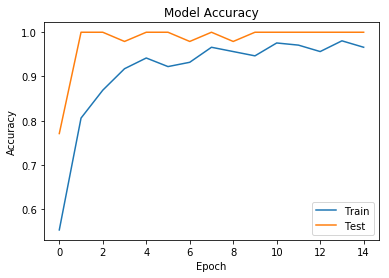

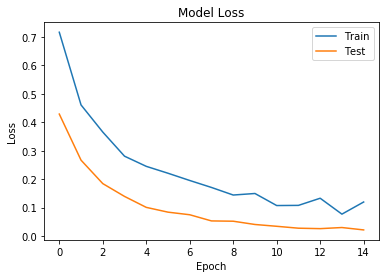

In [24]:
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['Train','Test'],loc='best')
plt.show()

plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['Train','Test'],loc='best')
plt.show()

### Evaluation

In [25]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       1.00      1.00      1.00        28
      normal       1.00      1.00      1.00        26

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54



#### Confusion matrix

Text(0.5, 1.0, 'Confusion Matrix')

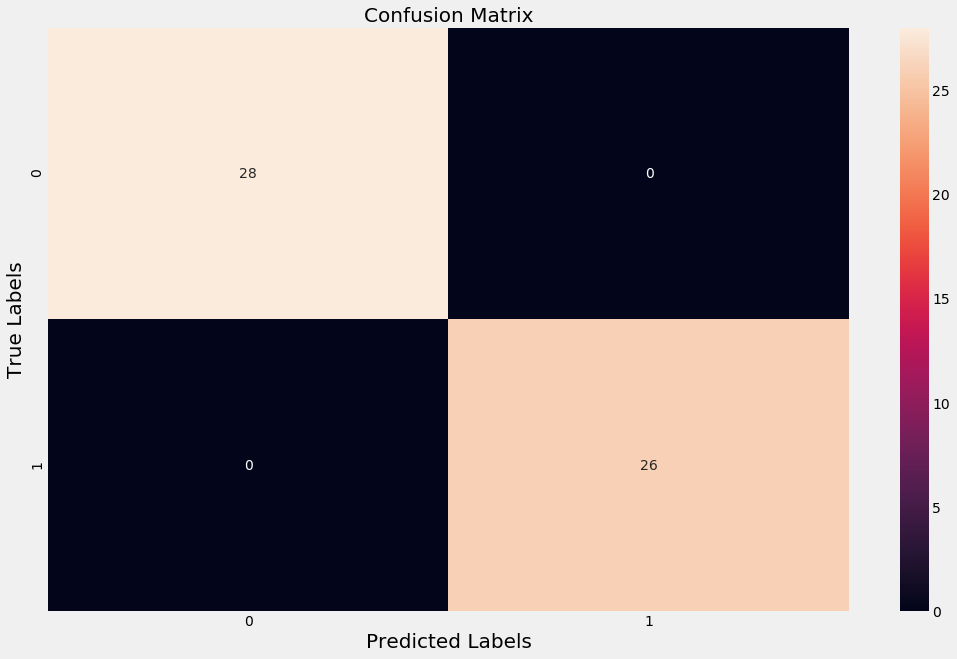

In [26]:
import seaborn as sns 
plt.style.use('fivethirtyeight')
matrix = confusion_matrix(predIdxs,testY.argmax(axis=1))
plt.figure(figsize=(16,10))
ax = plt.subplot()
sns.heatmap(matrix,annot=True,ax=ax)

ax.set_xlabel('Predicted Labels',size=20)
ax.set_ylabel('True Labels',size=20)
ax.set_title('Confusion Matrix',size=20)

# ax.xaxis.set_ticklabels(labels)
# ax.yaxis.set_ticklabels(labels)

In [27]:
# model.save("vgg16_with_random_state_{}.h5".format(random_value))

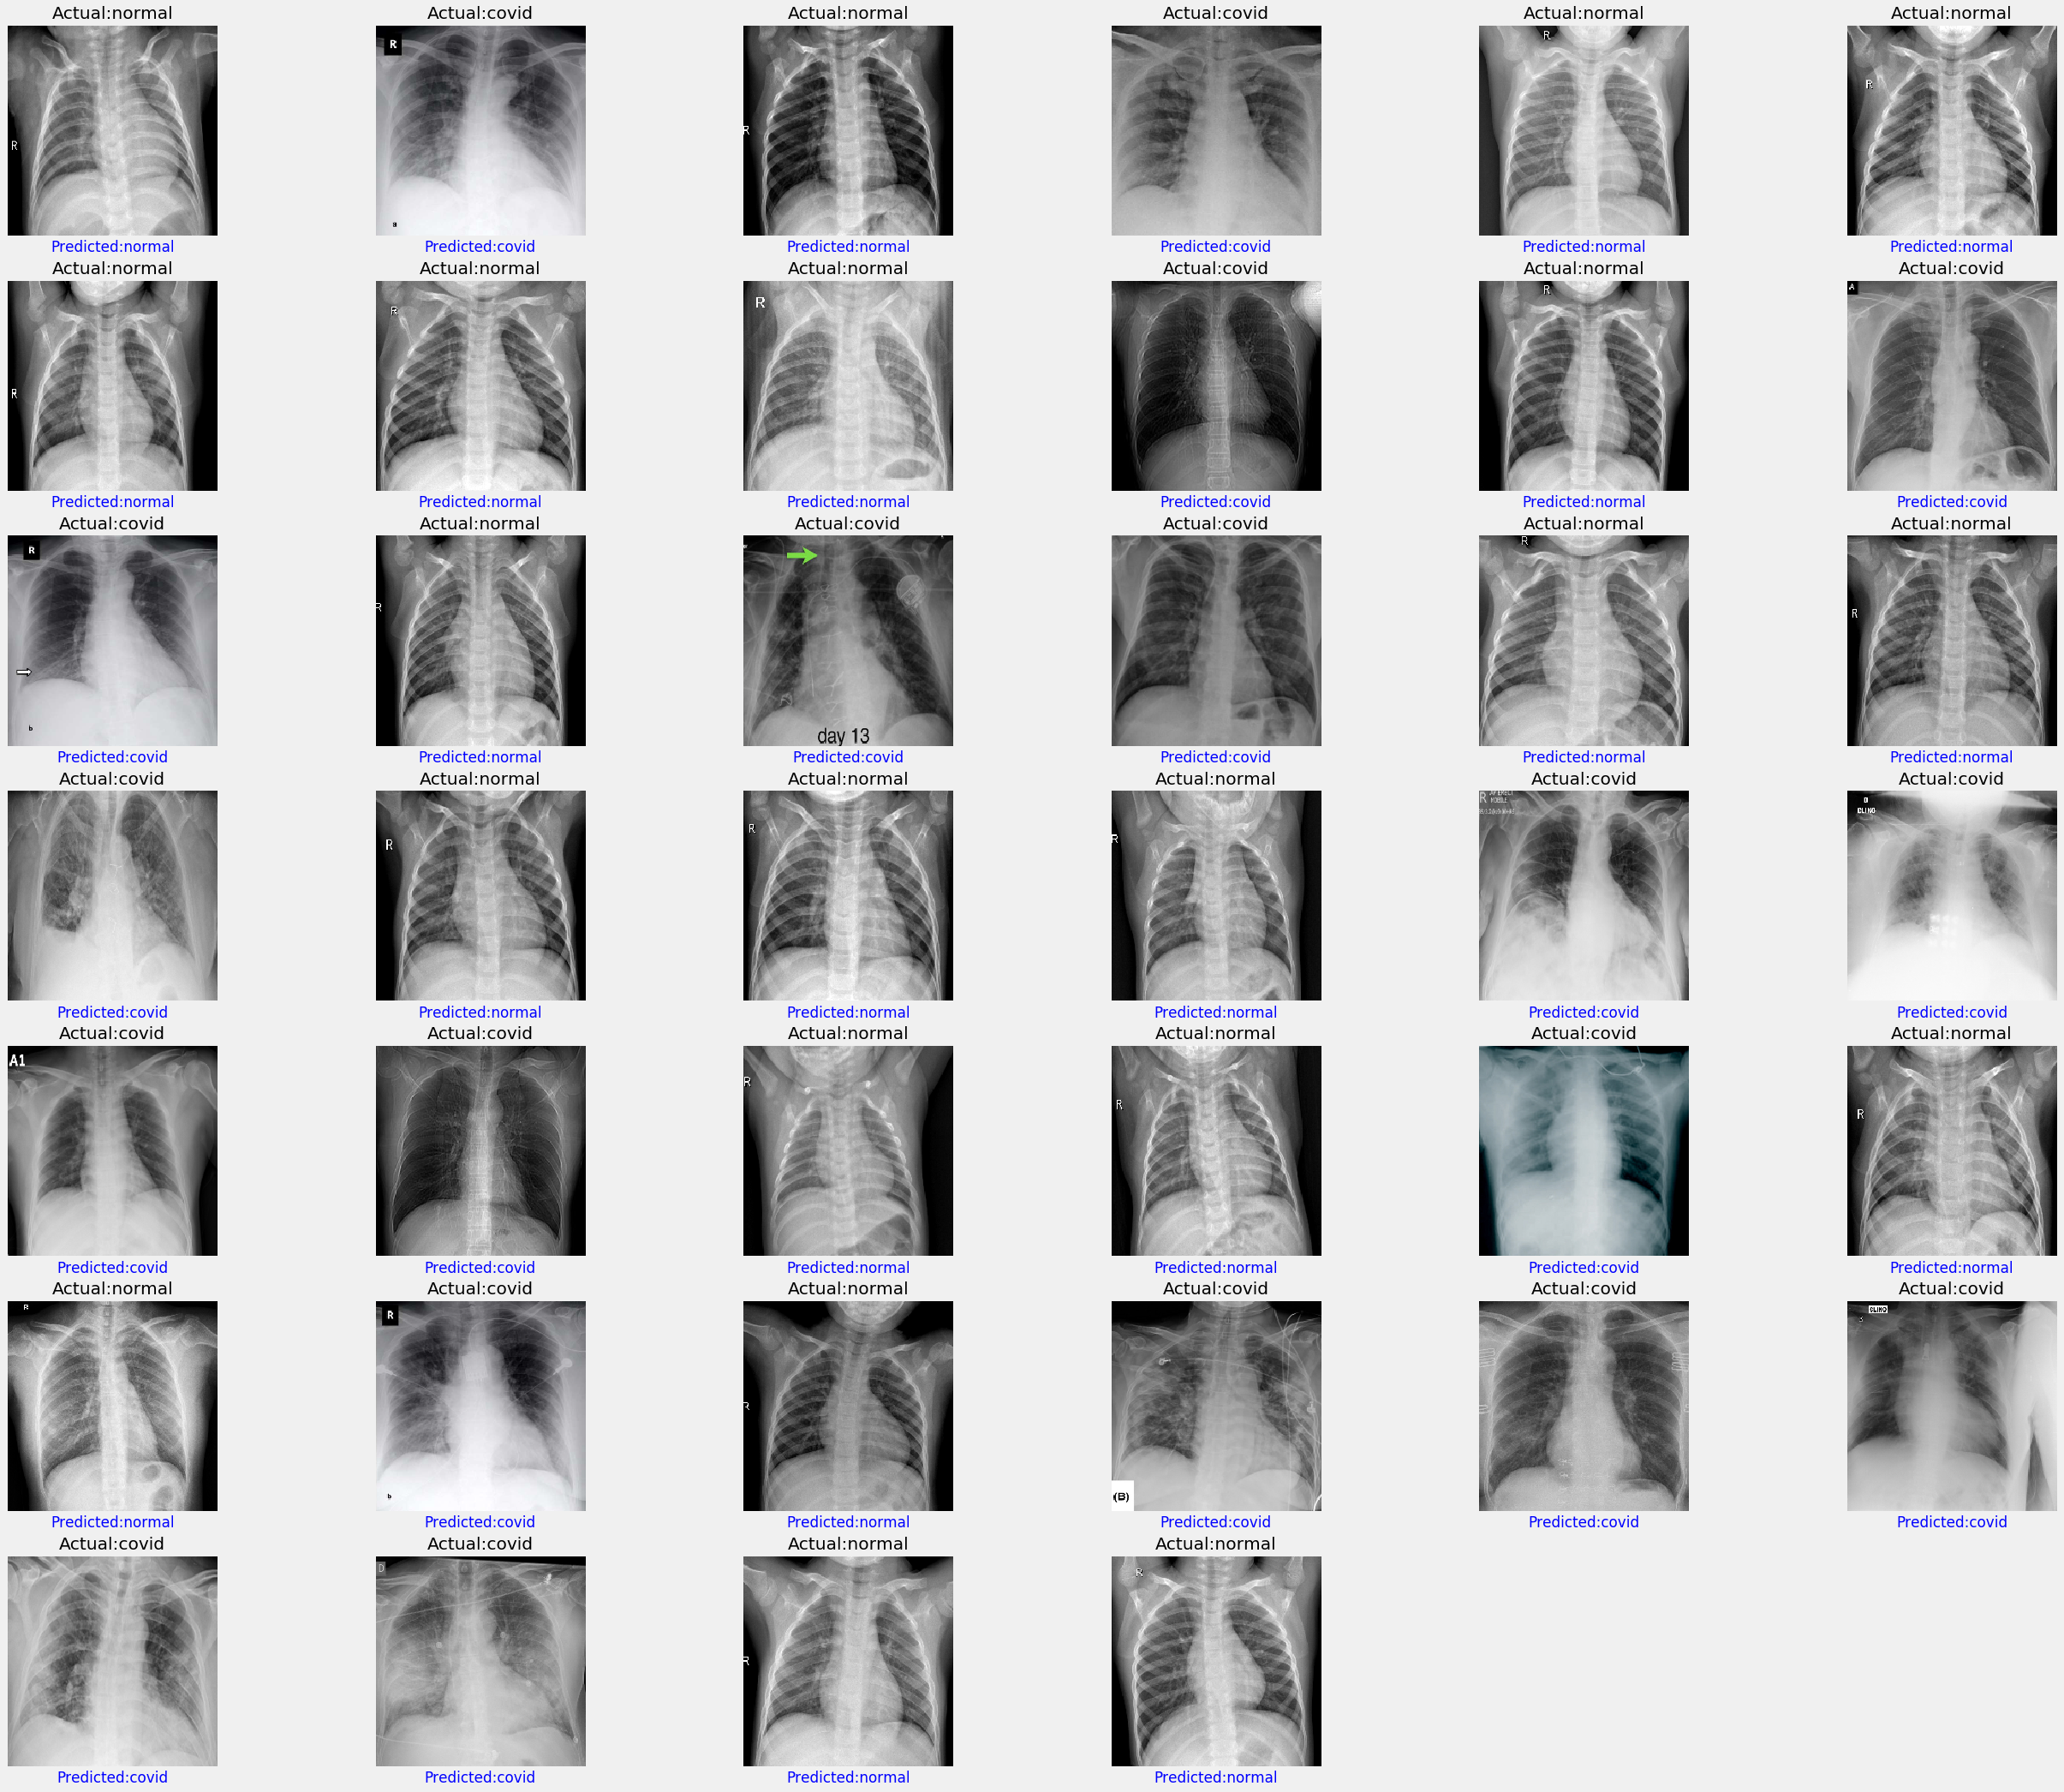

In [28]:
labels=['covid','normal']
plt.figure(figsize =(40,40))
for i in range(40):
    plt.subplot(8,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title("Actual:{}".format(labels[(np.argmax(testY[i], axis=0))]))
    plt.imshow(testX.reshape(-1,224,224,3)[i])
    
    if(predIdxs[i]==(np.argmax(testY[i], axis=0))):
        plt.xlabel("Predicted:{}".format(labels[predIdxs[i]]),color='blue')
    else:
        plt.xlabel("Predicted:{}".format(labels[predIdxs[i]]),color='red')
plt.show()

# AUC PRECISION RECALL curve

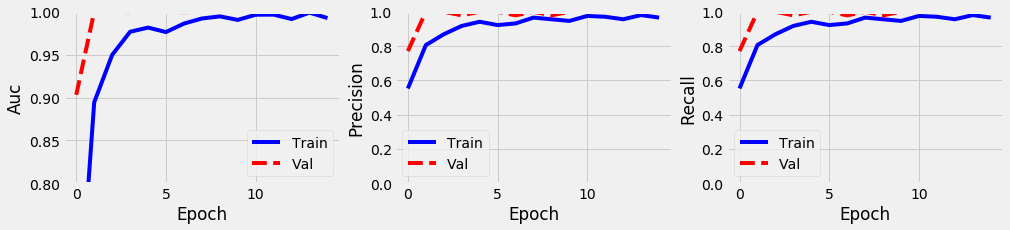

In [29]:
colors=['b','r']
def plot_metrics(H):
    plt.figure(figsize =(15,10))
    
    metrics =  [ 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        
        name = metric.replace("_"," ").capitalize()
        plt.subplot(3,3,n+1)
        plt.plot(H.epoch,  H.history[metric], color=colors[0], label='Train')
        plt.plot(H.epoch, H.history['val_'+metric],
                 color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()
plot_metrics(vgg_history)

# IBM - Adversarial Robustness TOoL


In [ ]:
pip install adversarial-robustness-toolbox

In [ ]:
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import KerasClassifier

In [ ]:
import tensorflow as tf

tf.compat.v1.enable_eager_execution()

In [ ]:
tf.compat.v1.disable_eager_execution()
classifier = KerasClassifier(model=model, clip_values=(0, 255), use_logits=False)

In [ ]:
attack = FastGradientMethod(estimator=model, eps=0.2)

# Foolbox Adversarial Attack

In [30]:
pip install foolbox==1.3.2

     |████████████████████████████████| 226 kB 9.2 MB/s eta 0:00:01
  Created wheel for foolbox: filename=foolbox-1.3.2-py3-none-any.whl size=243121 sha256=eb70b56159ae75cf089cbfe1867a062510da3005bb79e2437f88fae4f94ed80f
  Stored in directory: /root/.cache/pip/wheels/4f/e5/da/174670a1a2d2e1db7763417a7621b153abbd8d1b4634fee2b6
Successfully built foolbox
Note: you may need to restart the kernel to use updated packages.


In [31]:
import foolbox
from foolbox.models import KerasModel
from foolbox.attacks import FGSM
from foolbox.criteria import TargetClassProbability

In [32]:
attack_model = KerasModel(model,bounds=(0,255))
attack = FGSM(attack_model)

Using TensorFlow backend.


In [33]:
label=['covid','normal']

In [ ]:
#trying to find the gradient and see if the covid works
i=9
image = testX[i]
# print(label[np.argmax(model.predict(testX[1].reshape(1,224,224,3)))])
image_grad = attack_model.gradient(image,np.argmax(testY[i]))
# print(np.argmax(testY[1]))
adversarial_image = image + image_grad * 652
print(label[np.argmax(model.predict(testX[i].reshape(1,224,224,3)))])
print(label[np.argmax(model.predict(adversarial_image.reshape(1,224,224,3)))])
plt.imshow(image.reshape(224,224,3))


In [ ]:
plt.imshow(adversarial_image.reshape(224,224,3))

In [ ]:
k=1

In [ ]:
attack_image = attack(testX[k],(np.argmax(testY[k])))
print(label[np.argmax(model.predict(testX[k].reshape(1,224,224,3)))])
print(label[np.argmax(model.predict(attack_image.reshape(1,224,224,3)))])



In [ ]:
# attack_model2 = KerasModel(model,bounds=(0,255))
# attack2 = FGSM(attack_model2)
i=0
attack_image = attack(testX[i],(np.argmax(testY[i])))
print(label[np.argmax(model.predict(testX[i].reshape(1,224,224,3)))])
print(label[np.argmax(model.predict(attack_image.reshape(1,224,224,3)))])
i=1
attack_image = attack(testX[i],(np.argmax(testY[i])))
print(label[np.argmax(model.predict(testX[i].reshape(1,224,224,3)))])
print(label[np.argmax(model.predict(attack_image.reshape(1,224,224,3)))])
i=2
attack_image = attack(testX[i],(np.argmax(testY[i])))
print(label[np.argmax(model.predict(testX[i].reshape(1,224,224,3)))])
print(label[np.argmax(model.predict(attack_image.reshape(1,224,224,3)))])

In [ ]:
dict = {}
for i in range(len(testX)):
    attack_image = attack(testX[i],(np.argmax(testY[i])))
    if(attack_image is not None):
        key = i
        value = np.argmax(model.predict(attack_image.reshape(1,224,224,3)))
        dict.update({key:value})
    
    

In [ ]:
dict

In [ ]:
for k, v in dict.items():
    print (k, v)

In [ ]:
for k, v in dict.items():
    print (k, np.argmax(testY[k]))

# Find Accuracy

In [34]:
count_same =0
for k, v in dict.items():
    if(v==np.argmax(testY[k])):
        count_same=count_same + 1
        
print("Number of right Predictions : ",count_same)

if(count_same==0):
    print("Total Accuracy : Nil")
else:
    accuracy = (count_same/len(test(dict))) * 100
    
#     print(v,np.argmax(testY[k]))
#     print (k, np.argmax(testY[k]))

TypeError: descriptor 'items' of 'dict' object needs an argument

# ** *Above result proves that the training model can be 100% fooled. However five images can not be parsed due to gradient issue.***

## Here i try to work with gradient and episilon to handle the perturbations manually

In [ ]:
predIdxs,predIdxs[0],predIdxs[1]

In [35]:
import tensorflow as tf
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label,prediction):
    
      with tf.GradientTape() as tape:
        tape.watch(input_image)
#         prediction = pretrained_model(input_image)
        loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
      gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
      signed_grad = tf.sign(gradient)
      return signed_grad

In [36]:
grad = attack_model.gradient(testX[1],np.argmax(testY[1]))
print(grad)

[[[-8.9408604e-06 -1.1636895e-05 -1.9015206e-05]
  [-1.6070346e-05 -2.3110353e-05 -3.5808447e-05]
  [-1.7189996e-05 -2.9775627e-05 -4.2335865e-05]
  ...
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]]

 [[ 1.3609837e-05  1.5886762e-05 -6.0431166e-06]
  [ 2.2960932e-05  2.2155753e-05 -1.6132806e-05]
  [ 1.8204486e-05  6.2077061e-06 -3.4177625e-05]
  ...
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]]

 [[ 3.1742387e-05  3.5373621e-05 -7.9246238e-06]
  [ 6.1656028e-05  6.2759245e-05 -1.4611812e-05]
  [ 6.6527660e-05  4.9211510e-05 -3.6580612e-05]
  ...
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]]

 ...

 [[ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [ 0.0000000e+00  0.0000000e+00  0.000

In [37]:
signed_grad = tf.sign(grad)
print(signed_grad)

tf.Tensor(
[[[-1. -1. -1.]
  [-1. -1. -1.]
  [-1. -1. -1.]
  ...
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 1.  1. -1.]
  [ 1.  1. -1.]
  [ 1.  1. -1.]
  ...
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 1.  1. -1.]
  [ 1.  1. -1.]
  [ 1.  1. -1.]
  ...
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 ...

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  ...
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  ...
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  ...
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]], shape=(224, 224, 3), dtype=float32)


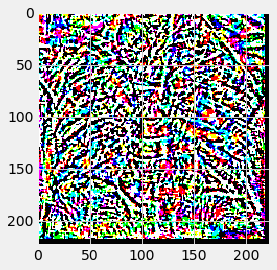

In [38]:
plt.imshow(signed_grad)

covid
covid


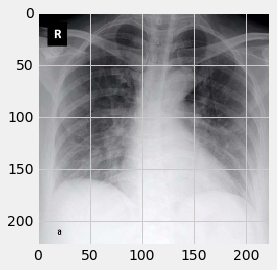

In [39]:
adversarial_image = testX[1]+(signed_grad*0.002)
adv_image = adversarial_image.numpy()

print(labels[np.argmax(model.predict(testX[1].reshape(1,224,224,3)))])
print(labels[np.argmax(model.predict(adv_image.reshape(1,224,224,3)))])
plt.imshow(adv_image.reshape(224,224,3))

In [40]:
i=47
eps=0.005
grad = attack_model.gradient(testX[i],np.argmax(testY[i]))
signed_grad = tf.sign(grad)
adversarial_image = testX[i]+(signed_grad*eps)
adv_image = adversarial_image.numpy()

print(labels[np.argmax(model.predict(testX[i].reshape(1,224,224,3)))])
print(labels[np.argmax(model.predict(adv_image.reshape(1,224,224,3)))])


normal
normal


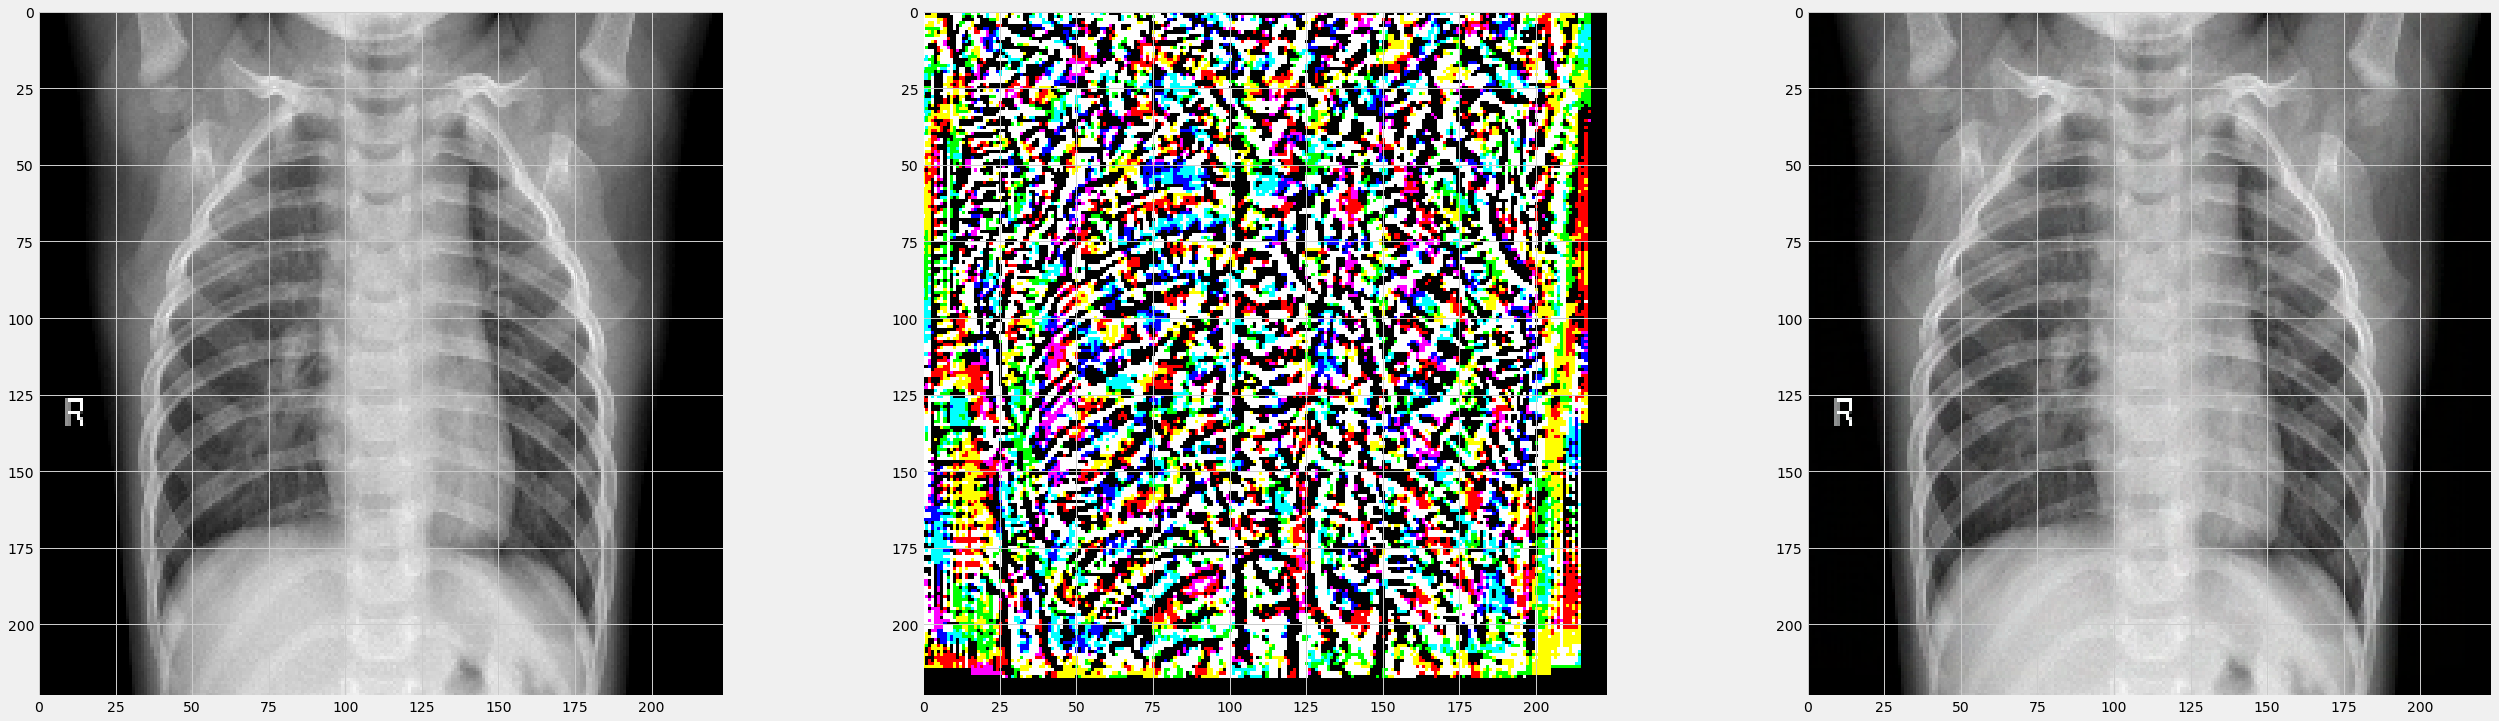

In [41]:

fig = plt.figure(figsize =(40,40))
ax1 = fig.add_subplot(3,3,1)
ax1.imshow(testX[i].reshape(224,224,3))
ax2 = fig.add_subplot(3,3,2)
ax2.imshow(signed_grad)
ax3 = fig.add_subplot(3,3,3)
ax3.imshow(adv_image.reshape(224,224,3))

In [ ]:
plt.figure(figsize=(40,40))
plt.subplot(3,3,1)
plt.title("Actual Label:Normal")
plt.imshow(testX[i].reshape(224,224,3))
plt.subplot(3,3,2)
plt.title("Perturbation",color='blue')
plt.imshow(signed_grad)
plt.subplot(3,3,3)
plt.title("Predicted Label:Covid",color='red')
plt.imshow(adv_image.reshape(224,224,3))

In [ ]:
import tensorflow as tf

In [ ]:
i=13
eps=0.009
grad = attack_model.gradient(testX[i],np.argmax(testY[i]))
signed_grad = tf.sign(grad)
adversarial_image = testX[i]+(signed_grad*eps)
adv_image = adversarial_image.numpy()

print(labels[np.argmax(model.predict(testX[i].reshape(1,224,224,3)))])
print(labels[np.argmax(model.predict(adv_image.reshape(1,224,224,3)))])
plt.figure(figsize=(40,40))
plt.subplot(3,3,1)
plt.title("Actual Label:Normal")
plt.imshow(testX[i].reshape(224,224,3))
plt.subplot(3,3,2)
plt.title("Perturbation",color='blue')
plt.imshow(signed_grad)
plt.subplot(3,3,3)
plt.title("Predicted Label:Covid",color='red')
plt.imshow(adv_image.reshape(224,224,3))

In [ ]:
i=13
eps=0.08
grad = attack_model.gradient(testX[i],np.argmax(testY[i]))
signed_grad = tf.sign(grad)
adversarial_image = testX[i]+(signed_grad*eps)
adv_image = adversarial_image.numpy()

print(labels[np.argmax(model.predict(testX[i].reshape(1,224,224,3)))])
print(labels[np.argmax(model.predict(adv_image.reshape(1,224,224,3)))])
plt.figure(figsize=(40,40))
plt.subplot(3,3,1)
plt.title("Actual Label:Normal")
plt.imshow(testX[i].reshape(224,224,3))
plt.subplot(3,3,2)
plt.title("Perturbation",color='blue')
plt.imshow(signed_grad)
plt.subplot(3,3,3)
plt.title("Predicted Label:Covid",color='red')
plt.imshow(adv_image.reshape(224,224,3))

In [ ]:
i=0
eps=.02
grad = attack_model.gradient(testX[i],np.argmax(testY[i]))
signed_grad = tf.sign(grad)
adversarial_image = testX[i]+(signed_grad*eps)
adv_image = adversarial_image.numpy()

print(labels[np.argmax(model.predict(testX[i].reshape(1,224,224,3)))])
print(labels[np.argmax(model.predict(adv_image.reshape(1,224,224,3)))])
plt.figure(figsize=(40,40))
plt.subplot(3,3,1)
plt.title("Actual Label:Normal")
plt.imshow(testX[i].reshape(224,224,3))
plt.subplot(3,3,2)
plt.title("Perturbation",color='blue')
plt.imshow(signed_grad)
plt.subplot(3,3,3)
plt.title("Predicted Label:Covid",color='red')
plt.imshow(adv_image.reshape(224,224,3))

In [ ]:
#now try to get altogether
epsilon =0.006
count_adv=0
vhul_count_adv=0
for k, v in dict.items():
    grad = attack_model.gradient(testX[k],np.argmax(testY[k]))
    signed_grad = tf.sign(grad)
    adversarial_image = testX[k]+(signed_grad*epsilon)
    adv_image = adversarial_image.numpy()
    orginal_pred = np.argmax(testY[k])
    adv_pred = np.argmax(model.predict(adv_image.reshape(1,224,224,3)))
    if(orginal_pred == adv_pred):
        count_adv=count_adv+1
        print("Prediction Milse : {} == {}".format(labels[orginal_pred],labels[adv_pred]))
    else:
        vhul_count_adv=vhul_count_adv+1
        print("Prediction Mile Nai : {} == {}".format(labels[orginal_pred],labels[adv_pred]))

print("Numbers of Correct Prediction with Adversarial : ",count_adv)
print("Numbers of Wrong Prediction with Adversarial : ",vhul_count_adv)
        

In [ ]:
#now try to get altogether
epsilon =1
count_adv=0
vhul_count_adv=0
for k, v in dict.items():
    grad = attack_model.gradient(testX[k],np.argmax(testY[k]))
    signed_grad = tf.sign(grad)
    adversarial_image = testX[k]+(signed_grad*epsilon)
    adv_image = adversarial_image.numpy()
    orginal_pred = np.argmax(testY[k])
    adv_pred = np.argmax(model.predict(adv_image.reshape(1,224,224,3)))
    if(orginal_pred == adv_pred):
        count_adv=count_adv+1
        print("Prediction Milse : {} == {}".format(labels[orginal_pred],labels[adv_pred]))
    else:
        vhul_count_adv=vhul_count_adv+1
        print("Prediction Mile Nai : {} == {}".format(labels[orginal_pred],labels[adv_pred]))

print("Numbers of Correct Prediction with Adversarial : ",count_adv)
print("Numbers of Wrong Prediction with Adversarial : ",vhul_count_adv)

In [ ]:
#for total image set in test
#now try to get altogether
epsilon =0
count_adv=0
vhul_count_adv=0
for k in range(len(testX)):
    grad = attack_model.gradient(testX[k],np.argmax(testY[k]))
    signed_grad = tf.sign(grad)
    adversarial_image = testX[k]+(signed_grad*epsilon)
    adv_image = adversarial_image.numpy()
    orginal_pred = np.argmax(testY[k])
    adv_pred = np.argmax(model.predict(adv_image.reshape(1,224,224,3)))
    if(orginal_pred == adv_pred):
        count_adv=count_adv+1
        print("Prediction Milse : {} == {}".format(labels[orginal_pred],labels[adv_pred]))
    else:
        vhul_count_adv=vhul_count_adv+1
        print("Prediction Mile Nai : {} == {}".format(labels[orginal_pred],labels[adv_pred]))

print("Numbers of Correct Prediction with Adversarial : ",count_adv)
print("Numbers of Wrong Prediction with Adversarial : ",vhul_count_adv)
        

## End of Manually Worked

In [ ]:
count_same =0
len(dict)

In [ ]:
attack_image = attack(testX[2],(np.argmax(testY[2])))
np.argmax(model.predict(attack_image.reshape(1,224,224,3)))
print(label[np.argmax(model.predict(testX[2].reshape(1,224,224,3)))])
print(label[np.argmax(model.predict(attack_image.reshape(1,224,224,3)))])

In [ ]:
if(attack_image is not None):
    print("yes")
else:
    print("no")

In [ ]:
for i in range(len(testX)):
    attack_image = attack(testX[i],(np.argmax(testY[i])))
    if(attack_image is not None):
        print(i)
    

In [ ]:
for i in range(len(testX)):
    attack_image = attack(testX[i],(np.argmax(testY[i])))
    if(attack_image is not None):
        print(i)
    

In [ ]:
final ={}
for i in range(len(testX)):
    attack_image = attack(testX[i],(np.argmax(testY[i])))
    if(attack_image is not None):
        print(i)
    
    

In [ ]:
attack_image = attack(testX[5],(np.argmax(testY[5],axis=0)))

In [ ]:
attack_image_adv = attack(adv_testX[5],(np.argmax(adv_testY[5],axis=0)))

In [ ]:
adv_trainX=trainX
adv_testX=testX
adv_trainY=trainY
adv_testY=testY

In [ ]:
print(attack_image_adv)

In [ ]:
print(attack_image)

In [ ]:
print(labels[np.argmax(model.predict(attack_image.reshape(1,224,224,3)))])
print(labels[np.argmax(model.predict(attack_image_adv.reshape(1,224,224,3)))])

In [ ]:
attack = FGSM(attack_model)
attack_image_adv1 = attack(testX[1],(np.argmax(testY[1],axis=0)))
print(attack_image_adv1)

In [ ]:
labels=['covid','normal']

In [ ]:
attack = FGSM(attack_model)
attack_image_adv1 = attack(testX[1],(np.argmax(testY[1],axis=0)))
attack1 = FGSM(attack_model)
attack_image_adv2 = attack1(testX[2],(np.argmax(testY[2],axis=0)))
print(labels[np.argmax(model.predict(testX[1].reshape(1,224,224,3)))])
print(labels[np.argmax(model.predict(testX[2].reshape(1,224,224,3)))])
print(labels[np.argmax(model.predict(attack_image_adv1.reshape(1,224,224,3)))])
print(labels[np.argmax(model.predict(attack_image_adv2.reshape(1,224,224,3)))])

In [ ]:
image_adver = attack_image

In [ ]:
plt.imshow(image_adver.reshape(224,224,3))

In [ ]:
plt.imshow(testX[2])

In [ ]:
image_adver.shape,attack_image.shape

In [ ]:
labels[np.argmax(model.predict(testX[2].reshape(1,224,224,3)))]

In [ ]:
labels[np.argmax(model.predict(image_adver.reshape(1,224,224,3)))]

In [ ]:
i=3
attack_image = attack(testX[3],(np.argmax(testY[3],axis=0)))
print(attack_image)
attack_image_adv = attack(adv_testX[3],(np.argmax(adv_testY[3],axis=0)))
print(attack_image_adv)

In [ ]:
image_adver = attack_image
image_adver.shape , attack_image.shape

In [ ]:
labels[np.argmax(model.predict(testX[5].reshape(1,224,224,3)))]

In [ ]:
np.argmax(model.predict(image_adver.reshape(1,224,224,3)))

In [ ]:
labels[np.argmax(model.predict(image_adver.reshape(1,224,224,3)))]

In [ ]:
np.argmax(testY[1])

In [ ]:
attack_vhul = attack(testX[8],(np.argmax(testY[8],axis=0)))

In [ ]:
attack_image = attack(adv_testX[3],(np.argmax(adv_testY[3])))
image_adversarial = attack_image
np.argmax(model.predict(image_adversarial.reshape(1,224,224,3)))

In [ ]:
#try first 5 images
adv_pred = []
for i in range(5):
    attack_image = attack(testX[i],(np.argmax(testY[i])))
    image_adversarial = attack_image
    pred = np.argmax(model.predict(image_adversarial.reshape(1,224,224,3)))
    adv_pred.append(pred)
    

***new try above***

In [ ]:
adv_model = KerasModel(model,bounds=(0,255))

In [ ]:
attack_FGSM = FGSM(model=adv_model)

In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:
i=10

In [ ]:
# testY[i]
pred_fgsm = []
pred_mod =[]

In [ ]:
j=12
advexp = attack_FGSM(testX[5],np.argmax(testY[5]))
pred_fgsm.append(np.argmax(model.predict(advexp.reshape(1,224,224,3))))

In [ ]:
pred_fgsm

In [ ]:
print(labels[np.argmax(testY[5],axis=0)])

In [ ]:
for j in range(20):
#     print(labels[np.argmax(testY[i],axis=0)])
    advexp = attack_FGSM(testX[j],np.argmax(testY[j]))
    pred_fgsm.append(np.argmax(model.predict(advexp.reshape(1,224,224,3))))

In [ ]:
pred_fgsm

In [ ]:
# attack_FGSM = FGSM(model=adv_model)


# print(labels[np.argmax(testY[i],axis=0)])
# i=4
# advexp = attack_FGSM(testX[i],np.argmax(testY[i]))
# print(advexp)
# adversarial = attack_FGSM(testX[i],np.argmax(testY[i],axis=0))
# advexp = attack_FGSM(testX[i],np.argmax(testY[i]))
# print(advexp)
# print(np.argmax(model.predict(advexp.reshape(1,224,224,3))))
# np.argmax(model.predict(advexp.reshape(1,224,224,3)))
# pred_fgsm.append(np.argmax(model.predict(advexp.reshape(1,224,224,3))))
# for j in range(20):
# #     testY[i]
#     print(labels[np.argmax(testY[j],axis=0)])
#     advexp = attack_FGSM(testX[j],np.argmax(testY[j]))
#     pred_fgsm.append(np.argmax(model.predict(advexp.reshape(1,224,224,3))))
j=12
print(labels[np.argmax(testY[i],axis=0)])
advexp = attack_FGSM(testX[i],np.argmax(testY[i]))
pred_fgsm.append(np.argmax(model.predict(advexp.reshape(1,224,224,3))))
    

In [ ]:
labels[0],labels[1]

In [ ]:
print(labels[np.argmax(testY[i],axis=0)])
np.argmax(testY[i],axis=0)

In [ ]:
np.argmax(testY[i],axis=0)

In [ ]:
advexp = attack_FGSM(testX[i],np.argmax(testY[i]))
print(advexp)

In [ ]:
np.argmax(model.predict(testX[i].reshape(1,224,224,3)))

In [ ]:
np.argmax(adv_model.predictions(advexp))

In [ ]:
#try to predict adv image with original model
np.argmax(model.predict(advexp.reshape(1,224,224,3)))

In [ ]:
#here i checked the output image and title of original model
plt.imshow(testX[1].reshape(224,224,3))
plt.title(labels[(np.argmax(testY[i], axis=0))])
plt.xlabel(labels[np.argmax(model.predict(testX[i].reshape(1,224,224,3)))])


In [ ]:
#here i checked the adversarial image and title with original model
plt.imshow(testX[i].reshape(224,224,3))
plt.title(labels[(np.argmax(testY[i], axis=0))])
plt.xlabel(labels[np.argmax(model.predict(advexp.reshape(1,224,224,3)))])

In [ ]:
#here i checked the output image and title of adversarial model
plt.imshow(advexp.reshape(224,224,3))
plt.title(labels[(np.argmax(testY[i], axis=0))])
plt.xlabel(labels[np.argmax(adv_model.predictions(advexp))])

In [ ]:
np.argmax(adv_model.predictions(advexp))

In [ ]:
#try to find the gradient of the original image
org_grad = adv_model.gradient(testX[i],np.argmax(testY[i],axis=0))


In [ ]:
org_image = testX[i]
plt.imshow(org_image)

In [ ]:
new_image_after_add_grad = org_image+np.multiply(org_grad,0.99)
plt.imshow(new_image_after_add_grad)

In [ ]:
#prediction of image after adding grad with original image
plt.imshow(testX[i].reshape(224,224,3))
plt.title(labels[(np.argmax(testY[i], axis=0))])
plt.xlabel(labels[np.argmax(model.predict(new_image_after_add_grad.reshape(1,224,224,3)))])

In [ ]:
#here i add test image with fgsm attacked gradient and then put into our original model to predict the new image
new_image  = testX[i]+advexp*0.99
plt.imshow(new_image.reshape(224,224,3))
plt.title(labels[(np.argmax(testY[i], axis=0))])
plt.xlabel(labels[np.argmax(model.predict(new_image.reshape(1,224,224,3)))])

In [ ]:
plt.imshow(new_image.reshape(224,224,3))
plt.title(labels[(np.argmax(testY[i], axis=0))])
plt.xlabel(labels[np.argmax(adv_model.predictions(new_image))])

In [ ]:
plt.imshow(new_image)

In [ ]:
plt.imshow(advexp)

In [ ]:
plt.imshow(new_image_after_add_grad.reshape(224,224,3))

In [ ]:
model.evaluate(testX,testY)

# Try to implement for sars

In [43]:
dataset_path = './dataset2'

In [44]:
%%bash
rm -rf dataset2
mkdir -p dataset2/Sars
mkdir -p dataset2/Normal

In [45]:
for (i, row) in df.iterrows():
    # if (1) the current case is not COVID-19 or (2) this is not
    # a 'PA' view, then ignore the row
    if row["finding"] != "SARS":
        continue

    # build the path to the input image file
    imagePath = os.path.sep.join([covid_dataset_path, "images", row["filename"]])

    # if the input image file does not exist (there are some errors in
    # the COVID-19 metadeta file), ignore the row
    if not os.path.exists(imagePath):
        continue

    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = row["filename"].split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/Sars", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

In [46]:
basePath = os.path.sep.join([pneumonia_dataset_path, "train", "NORMAL"])
imagePaths = list(paths.list_images(basePath))
# print("ImagePath {}\n".format(imagePaths))



# randomly sample the image paths
random.seed(random_value) #47
random.shuffle(imagePaths)
imagePaths = imagePaths[:25] 
"""
[:@]
If @ is following -
#70 and 50 is good
#35 and 25(as given) is better(and same)
"""
# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/Normal", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

In [47]:
path, dirs, files1 = next(os.walk("../working/dataset2/Sars/"))
print(len(files1))
path, dirs, files2 = next(os.walk("../working/dataset2/Normal/"))
print(len(files2))

print(len(files1)+len(files2))

16
25
41


In [48]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
# print(len(paths.list_images(dataset_path)))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

[INFO] loading images...


In [49]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [50]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.10,stratify=labels, random_state=random_value)
# initialize the training data augmentation object
print("Size of train image : {} and train label : {}".format(len(trainX),len(trainY)))
print("Size of test image : {} and test label : {}".format(len(testX),len(testY)))
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

Size of train image : 36 and train label : 36
Size of test image : 5 and test label : 5


In [51]:
y_train = trainY.tolist()
print("Total data in train set : ",len(y_train))

sars=0
nonsars=0

for idx,i in enumerate(y_train):
    if(i == [1.0, 0.0]):
        sars+=1
    else:
        nonsars+=1
print("In distribution of train Sars = {} and Normal = {}".format(sars,nonsars))

y_test = testY.tolist()
print("Total data in test set : ",len(y_test))
sars=0
nonsars=0

for idx,i in enumerate(y_test):
    if(i == [1.0, 0.0]):
        sars+=1
    else:
        nonsars+=1
print("In distribution of test Sars = {} and Normal = {}".format(sars,nonsars))

Total data in train set :  36
In distribution of train Sars = 22 and Normal = 14
Total data in test set :  5
In distribution of test Sars = 3 and Normal = 2


In [55]:
print("[INFO] compiling model...")
BS=1
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=METRICS)
callbacks = [ EarlyStopping(monitor='val_loss',patience=4),
             ModelCheckpoint(filepath='Vgg16_best_till_now.h5',monitor='val_loss',save_best_only=True)
            ]

# train the head of the network
print("[INFO] training head...")
vgg_history = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
#     callbacks=callbacks,
)

[INFO] compiling model...
[INFO] training head...
Train for 36 steps, validate on 5 samples
Epoch 1/15
36/36 [==============================] - 3s 90ms/step - loss: 0.5446 - accuracy: 0.7500 - tp: 27.0000 - fp: 9.0000 - tn: 27.0000 - fn: 9.0000 - precision: 0.7500 - recall: 0.7500 - auc: 0.8426 - val_loss: 0.5104 - val_accuracy: 0.8000 - val_tp: 4.0000 - val_fp: 1.0000 - val_tn: 4.0000 - val_fn: 1.0000 - val_precision: 0.8000 - val_recall: 0.8000 - val_auc: 0.8800
Epoch 2/15
36/36 [==============================] - 1s 30ms/step - loss: 0.5342 - accuracy: 0.7222 - tp: 26.0000 - fp: 10.0000 - tn: 26.0000 - fn: 10.0000 - precision: 0.7222 - recall: 0.7222 - auc: 0.8256 - val_loss: 0.4800 - val_accuracy: 0.8000 - val_tp: 4.0000 - val_fp: 1.0000 - val_tn: 4.0000 - val_fn: 1.0000 - val_precision: 0.8000 - val_recall: 0.8000 - val_auc: 0.8800
Epoch 3/15
36/36 [==============================] - 1s 23ms/step - loss: 0.5178 - accuracy: 0.7500 - tp: 27.0000 - fp: 9.0000 - tn: 27.0000 - fn: 9.0000

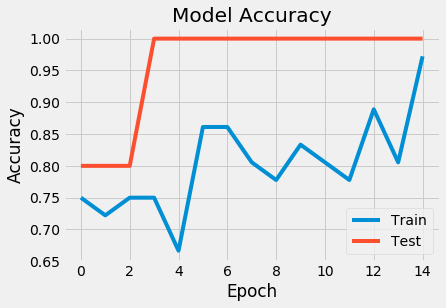

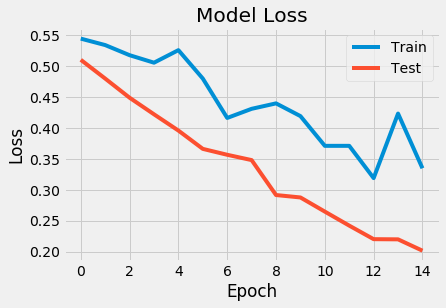

In [56]:
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['Train','Test'],loc='best')
plt.show()

plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['Train','Test'],loc='best')
plt.show()

In [57]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00         3
        Sars       1.00      1.00      1.00         2

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



Text(0.5, 1.0, 'Confusion Matrix')

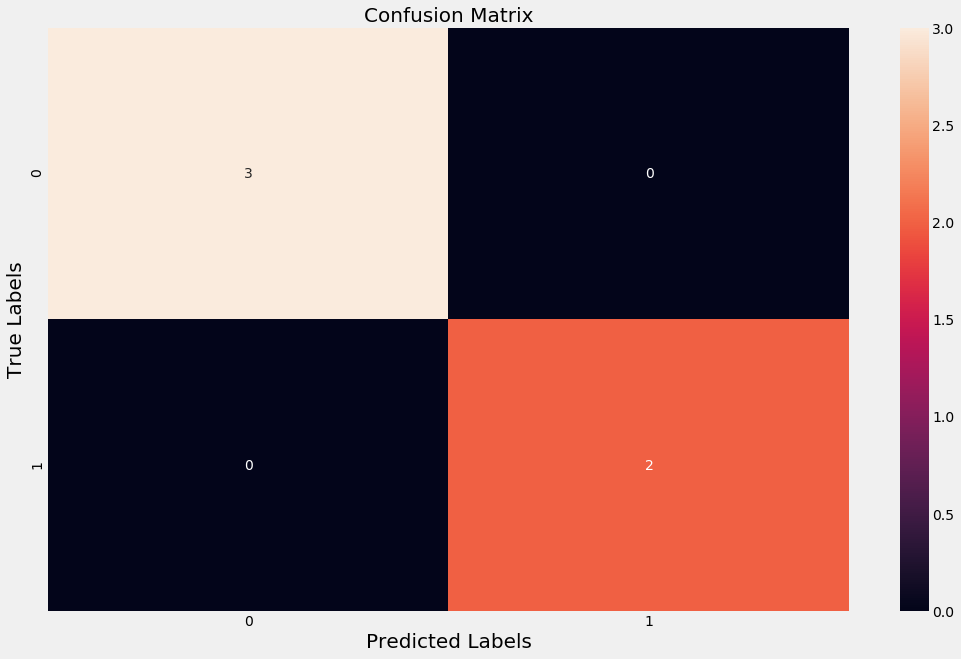

In [58]:
import seaborn as sns 
plt.style.use('fivethirtyeight')
matrix = confusion_matrix(predIdxs,testY.argmax(axis=1))
plt.figure(figsize=(16,10))
ax = plt.subplot()
sns.heatmap(matrix,annot=True,ax=ax)

ax.set_xlabel('Predicted Labels',size=20)
ax.set_ylabel('True Labels',size=20)
ax.set_title('Confusion Matrix',size=20)

# ax.xaxis.set_ticklabels(labels)
# ax.yaxis.set_ticklabels(labels)

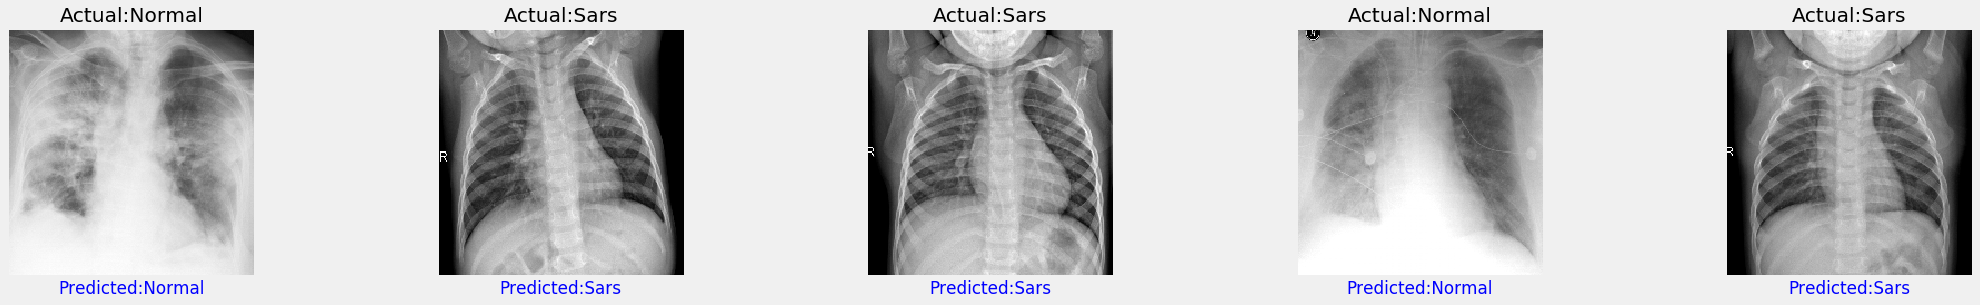

In [59]:
labels=['Sars','Normal']
plt.figure(figsize =(40,40))
for i in range(len(testX)):
    plt.subplot(8,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title("Actual:{}".format(labels[(np.argmax(testY[i], axis=0))]))
    plt.imshow(testX.reshape(-1,224,224,3)[i])
    
    if(predIdxs[i]==(np.argmax(testY[i], axis=0))):
        plt.xlabel("Predicted:{}".format(labels[predIdxs[i]]),color='blue')
    else:
        plt.xlabel("Predicted:{}".format(labels[predIdxs[i]]),color='red')
plt.show()

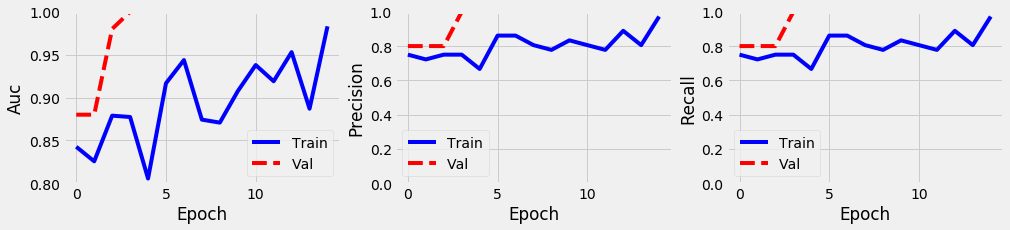

In [60]:
colors=['b','r']
def plot_metrics(H):
    plt.figure(figsize =(15,10))
    
    metrics =  [ 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        
        name = metric.replace("_"," ").capitalize()
        plt.subplot(3,3,n+1)
        plt.plot(H.epoch,  H.history[metric], color=colors[0], label='Train')
        plt.plot(H.epoch, H.history['val_'+metric],
                 color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()
plot_metrics(vgg_history)

In [61]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00         3
        Sars       1.00      1.00      1.00         2

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



# Foolbox attack on SARS

In [62]:
attack_model_sars = KerasModel(model,bounds=(0,255))
attack_sars = FGSM(attack_model_sars)

In [67]:
i=2
eps=0.02
grad = attack_model_sars.gradient(testX[i],np.argmax(testY[i]))
signed_grad = tf.sign(grad)
adversarial_image = testX[i]+(signed_grad*eps)
adv_image = adversarial_image.numpy()
org_label=labels[np.argmax(model.predict(testX[i].reshape(1,224,224,3)))]
adv_pred_label=labels[np.argmax(model.predict(adv_image.reshape(1,224,224,3)))]
print(org_label)
print(adv_pred_label)

Sars
Normal


In [1]:
plt.figure(figsize=(40,40))
plt.subplot(3,3,1)
plt.title("Actual Label:{}".format(org_label))
plt.imshow(testX[i].reshape(224,224,3))
plt.subplot(3,3,2)
plt.title("Perturbation",color='blue')
plt.imshow(signed_grad)
plt.subplot(3,3,3)
plt.title("Predicted Label:{}".format(adv_pred_label),color='red')
plt.imshow(adv_image.reshape(224,224,3))

NameError: name 'plt' is not defined

# Inception V3 Model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

image_size = 224
pre_trained_model = InceptionV3(
  input_shape = (image_size, image_size, 3),
  include_top = False,
  weights = 'imagenet')

for layer in pre_trained_model.layers:
    
    layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

In [ ]:
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.4
x = layers.Dropout(0.4)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(2, activation='sigmoid')(x)

v3_model = Model(pre_trained_model.input, x)

In [ ]:
v3_model.compile(
  optimizer = Adam(lr=INIT_LR), 
  loss = 'binary_crossentropy', 
  metrics = METRICS)

In [ ]:
callbacks = [ EarlyStopping(monitor='val_loss',patience=4),
             ModelCheckpoint(filepath='InceptionV3_best_till_now.h5',monitor='val_loss',save_best_only=True)
    
]
incept_history = v3_model.fit(
  trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
# callbacks=callbacks
)

In [ ]:
plt.plot(incept_history.history['accuracy'])
plt.plot(incept_history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['Train','Test'],loc='best')
plt.show()

plt.plot(incept_history.history['loss'])
plt.plot(incept_history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['Train','Test'],loc='best')
plt.show()

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = v3_model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))



In [ ]:
import seaborn as sns 
plt.style.use('fivethirtyeight')
matrix = confusion_matrix(predIdxs,testY.argmax(axis=1))
plt.figure(figsize=(8,8))
ax = plt.subplot()
sns.heatmap(matrix,annot=True,ax=ax)

ax.set_xlabel('Predicted Labels',size=20)
ax.set_ylabel('True Labels',size=20)
ax.set_title('Confusion Matrix(0=Covid and 1=NonCovid)',size=20)

In [ ]:
# model.save_weights("inceptionv3_weights_at_random_state_{}.h5".format(random_value))

In [ ]:
labels=['covid','normal']
plt.figure(figsize =(40,40))
for i in range(40):
    plt.subplot(7,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title("Actual:{}".format(labels[(np.argmax(testY[i], axis=0))]))
    plt.imshow(testX.reshape(-1,224,224,3)[i])
    
    if(predIdxs[i]==(np.argmax(testY[i], axis=0))):
        plt.xlabel("Predicted:{}".format(labels[predIdxs[i]]),color='blue')
    else:
        plt.xlabel("Predicted:{}".format(labels[predIdxs[i]]),color='red')
plt.show()

In [ ]:
colors=['b','r']
def plot_metrics(H):
    plt.figure(figsize =(20,15))
    
    metrics =  [ 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        
        name = metric.replace("_"," ").capitalize()
        plt.subplot(3,3,n+1)
        plt.plot(H.epoch,  H.history[metric], color=colors[0], label='Train')
        plt.plot(H.epoch, H.history['val_'+metric],
                 color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()
plot_metrics(incept_history)

In [ ]:
attack_model_incpt = KerasModel(v3_model,bounds=(0,255))
attack_incpt = FGSM(attack_model_incpt)

In [ ]:
dict_incpt = {}
for i in range(len(testX)):
    attack_image = attack_incpt(testX[i],(np.argmax(testY[i])))
    if(attack_image is not None):
        key = i
        value = np.argmax(v3_model.predict(attack_image.reshape(1,224,224,3)))
        dict_incpt.update({key:value})
    

In [ ]:
dict_incpt

In [ ]:
count_same =0
for k, v in dict_incpt.items():
    if(v==np.argmax(testY[k])):
        count_same=count_same + 1
        
print("Number of right Predictions : ",count_same)

if(count_same==0):
    print("Total Accuracy : Nil")
else:
    accuracy = (count_same/len(test(dict))) * 100

In [ ]:
i=31
eps=0.007
grad = attack_model_incpt.gradient(testX[i],np.argmax(testY[i]))
signed_grad = tf.sign(grad)
print(signed_grad)
adversarial_image = testX[i]+(signed_grad*eps)
adv_image = adversarial_image.numpy()

print(labels[np.argmax(v3_model.predict(testX[i].reshape(1,224,224,3)))])
print(labels[np.argmax(v3_model.predict(adv_image.reshape(1,224,224,3)))])


In [ ]:

fig = plt.figure(figsize =(40,40))
ax1 = fig.add_subplot(3,3,1)
ax1.imshow(testX[i].reshape(224,224,3))
ax2 = fig.add_subplot(3,3,2)
ax2.imshow(signed_grad)
ax3 = fig.add_subplot(3,3,3)
ax3.imshow(adv_image.reshape(224,224,3))

In [ ]:
#for total image set in test
#now try to get altogether
epsilon =0
count_adv=0
vhul_count_adv=0
for k in range(len(testX)):
    grad = attack_model_incpt.gradient(testX[k],np.argmax(testY[k]))
    signed_grad = tf.sign(grad)
    adversarial_image = testX[k]+(signed_grad*epsilon)
    adv_image = adversarial_image.numpy()
    orginal_pred = np.argmax(testY[k])
    adv_pred = np.argmax(v3_model.predict(adv_image.reshape(1,224,224,3)))
    if(orginal_pred == adv_pred):
        count_adv=count_adv+1
        print("Prediction Milse : {} == {}".format(labels[orginal_pred],labels[adv_pred]))
    else:
        vhul_count_adv=vhul_count_adv+1
        print("Prediction Mile Nai : {} == {}".format(labels[orginal_pred],labels[adv_pred]))

print("Numbers of Correct Prediction with Adversarial : ",count_adv)
print("Numbers of Wrong Prediction with Adversarial : ",vhul_count_adv)

In [ ]:
import tensorflow as tf

In [ ]:
i=13
eps=.009
grad = attack_model_incpt.gradient(testX[i],np.argmax(testY[i]))
signed_grad = tensorflow.sign(grad)
adversarial_image = testX[i]+(signed_grad*eps)
adv_image = adversarial_image.numpy()

print(labels[np.argmax(v3_model.predict(testX[i].reshape(1,224,224,3)))])
print(labels[np.argmax(v3_model.predict(adv_image.reshape(1,224,224,3)))])
plt.figure(figsize=(40,40))
plt.subplot(3,3,1)
plt.title("Actual Label:Normal")
plt.imshow(testX[i].reshape(224,224,3))
plt.subplot(3,3,2)
plt.title("Perturbation",color='blue')
plt.imshow(signed_grad)
plt.subplot(3,3,3)
plt.title("Predicted Label:Covid",color='red')
plt.imshow(adv_image.reshape(224,224,3))

In [ ]:
i=13
eps=.08
grad = attack_model_incpt.gradient(testX[i],np.argmax(testY[i]))
signed_grad = tensorflow.sign(grad)
adversarial_image = testX[i]+(signed_grad*eps)
adv_image = adversarial_image.numpy()

print(labels[np.argmax(v3_model.predict(testX[i].reshape(1,224,224,3)))])
print(labels[np.argmax(v3_model.predict(adv_image.reshape(1,224,224,3)))])
plt.figure(figsize=(40,40))
plt.subplot(3,3,1)
plt.title("Actual Label:Normal")
plt.imshow(testX[i].reshape(224,224,3))
plt.subplot(3,3,2)
plt.title("Perturbation",color='blue')
plt.imshow(signed_grad)
plt.subplot(3,3,3)
plt.title("Predicted Label:Covid",color='red')
plt.imshow(adv_image.reshape(224,224,3))

In [ ]:
i=0
eps=.02
grad = attack_model_incpt.gradient(testX[i],np.argmax(testY[i]))
signed_grad = tf.sign(grad)
adversarial_image = testX[i]+(signed_grad*eps)
adv_image = adversarial_image.numpy()

print(labels[np.argmax(v3_model.predict(testX[i].reshape(1,224,224,3)))])
print(labels[np.argmax(v3_model.predict(adv_image.reshape(1,224,224,3)))])
plt.figure(figsize=(40,40))
plt.subplot(3,3,1)
plt.title("Actual Label:Normal")
plt.imshow(testX[i].reshape(224,224,3))
plt.subplot(3,3,2)
plt.title("Perturbation",color='blue')
plt.imshow(signed_grad)
plt.subplot(3,3,3)
plt.title("Predicted Label:Covid",color='red')
plt.imshow(adv_image.reshape(224,224,3))

In [ ]:
i=53
eps=.002
grad = attack_model_incpt.gradient(testX[i],np.argmax(testY[i]))
signed_grad = tf.sign(grad)
adversarial_image = testX[i]+(signed_grad*eps)
adv_image = adversarial_image.numpy()

print(labels[np.argmax(v3_model.predict(testX[i].reshape(1,224,224,3)))])
print(labels[np.argmax(v3_model.predict(adv_image.reshape(1,224,224,3)))])
plt.figure(figsize=(40,40))
plt.subplot(3,3,1)
plt.title("Actual Label:Normal")
plt.imshow(testX[i].reshape(224,224,3))
plt.subplot(3,3,2)
plt.title("Perturbation",color='blue')
plt.imshow(signed_grad)
plt.subplot(3,3,3)
plt.title("Predicted Label:Covid",color='red')
plt.imshow(adv_image.reshape(224,224,3))

# implementing foolbox on inception

In [ ]:
pip install foolbox==2.4.0

In [ ]:
import foolbox
# from foolbox.models import TensorFlowModel
from foolbox.attacks import FGSM
# from foolbox.criteria import TargetClassProbability

In [ ]:
import foolbox
foolbox.__version__

In [ ]:
attack_incept = foolbox.models.KerasModel(v3_model,bounds=(0,255))

In [ ]:
fgsm_attack = foolbox.v1.attacks.FGSM(attack_incept)

In [ ]:
# testX[1].shape,testY[1].shape
image = testX[1]
lab =np.argmax(testY[1],axis=0)

In [ ]:
trainX[0].shape

In [ ]:
plt.imshow(trainX[0])

In [ ]:
adversarial = fgsm_attack(trainX[1],np.argmax(trainY[1],axis=0))
print(adversarial)

In [ ]:
plt.imshow(adversarial)

In [ ]:
np.argmax(v3_model.predict(trainX[0].reshape(1,224,224,3)),axis=0)

In [ ]:
np.argmax(v3_model.predict(trainX[0].reshape(1,224,224,3), batch_size=1))

In [ ]:
trainY[0]

In [ ]:
np.argmax(v3_model.predict(adversarial.reshape(1,224,224,3), batch_size=1))

In [ ]:
plt.imshow(trainX[1])

In [ ]:
pgd = foolbox.attacks.ProjectedGradientDescentAttack(attack_incept)

In [ ]:
adv = pgd(testX[0],testY[0])

# Resnet50

In [ ]:
# from tensorflow.keras.applications.resnet50 import ResNet50
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import GlobalAveragePooling2D,Dense,Dropout,BatchNormalization,Flatten
# image_size=224
# RESNET50_POOLING_AVERAGE = 'avg'
# DENSE_LAYER_ACTIVATION = 'softmax'
# # resnet_model = Sequential()
# # resnet_model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))

# # resnet_model.add(Dense(2, activation = DENSE_LAYER_ACTIVATION))
# # resnet_model.layers[0].trainable = False

# model = ResNet50(weights='imagenet', input_shape = (image_size, image_size, 3),include_top=False)


# result = model.output
# result = GlobalAveragePooling2D()(result)
# result = Flatten()(result)
# # add a fully-connected layer
# result = Dense(512, activation='relu')(result)
# result= Dropout(0.5)(result)
# # result = BatchNormalization()(result)
# result = Dense(256, activation='relu')(result)
# result= Dropout(0.3)(result)
# result = Dense(128, activation='relu')(result)
# # and a fully connected output/classification layer
# predictions = Dense(2, activation='sigmoid')(result)
# resnet_model = Model(inputs=model.input, outputs=predictions)

# for layer in resnet_model.layers[0:141]:
#     layer.trainable = False


In [ ]:
# resnet_model.compile(
#   optimizer = Adam(lr=INIT_LR), 
#   loss = 'binary_crossentropy', 
#   metrics = METRICS)

In [ ]:
# callbacks = [ EarlyStopping(monitor='val_loss',patience=4),
#              ModelCheckpoint(filepath='resnet_best_till_now.h5',monitor='val_loss',save_best_only=True)
    
# ]
# resnet_history = resnet_model.fit(
#   trainAug.flow(trainX, trainY, batch_size=BS),
#     steps_per_epoch=len(trainX) // BS,
#     validation_data=(testX, testY),
#     validation_steps=len(testX) // BS,
#     epochs=EPOCHS,
   
# # callbacks=callbacks
# )

In [ ]:
# plt.plot(resnet_history.history['accuracy'])
# plt.plot(resnet_history.history['val_accuracy'])
# plt.title("Model Accuracy")
# plt.ylabel("Accuracy")
# plt.xlabel("Epoch")
# plt.legend(['Train','Test'],loc='best')
# plt.show()

# plt.plot(resnet_history.history['loss'])
# plt.plot(resnet_history.history['val_loss'])
# plt.title("Model Loss")
# plt.ylabel("Loss")
# plt.xlabel("Epoch")
# plt.legend(['Train','Test'],loc='best')
# plt.show()


In [ ]:
# import warnings
# warnings.filterwarnings('always')

In [ ]:


# # make predictions on the testing set
# print("[INFO] evaluating network...")
# predIdxs_res = resnet_model.predict(testX, batch_size=BS)
# # for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
# predIdxs_res = np.argmax(predIdxs_res, axis=1)
# # show a nicely formatted classification report
# print(classification_report(testY.argmax(axis=1), predIdxs_res, target_names=lb.classes_))

# print(lb.classes_)

In [ ]:
# import seaborn as sns 
# plt.style.use('fivethirtyeight')
# matrix = confusion_matrix(predIdxs_res,testY.argmax(axis=1))
# plt.figure(figsize=(8,8))
# ax = plt.subplot()
# sns.heatmap(matrix,annot=True,ax=ax)

# ax.set_xlabel('Predicted Labels',size=20)
# ax.set_ylabel('True Labels',size=20)
# ax.set_title('Confusion Matrix(0=Covid and 1=NonCovid)',size=20)

In [ ]:
# colors=['b','r']
# def plot_metrics(H):
#     plt.figure(figsize =(15,10))
    
#     metrics =  [ 'auc', 'precision', 'recall']
#     for n, metric in enumerate(metrics):
        
#         name = metric.replace("_"," ").capitalize()
#         plt.subplot(3,3,n+1)
#         plt.plot(H.epoch,  H.history[metric], color=colors[0], label='Train')
#         plt.plot(H.epoch, H.history['val_'+metric],
#                  color=colors[1], linestyle="--", label='Val')
#         plt.xlabel('Epoch')
#         plt.ylabel(name)
#         if metric == 'loss':
#             plt.ylim([0, plt.ylim()[1]])
#         elif metric == 'auc':
#             plt.ylim([0.8,1])
#         else:
#             plt.ylim([0,1])

#         plt.legend()
# plot_metrics(resnet_history)

In [ ]:
# resnet_model.save("resnet_with_random_state_{}.h5".format(random_value))

In [ ]:
# labels=['covid','normal']
# plt.figure(figsize =(40,40))
# for i in range(31):
#     plt.subplot(7,5,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.title(labels[(np.argmax(testY[i], axis=0))])
#     plt.imshow(testX.reshape(-1,224,224,3)[i])
    
#     if(predIdxs[i]==(np.argmax(testY[i], axis=0))):
#         plt.xlabel(labels[predIdxs[i]],color='blue')
#     else:
#         plt.xlabel(labels[predIdxs[i]],color='red')
# plt.show()

# Dense Net 121

In [ ]:
# from tensorflow.keras.applications import DenseNet121
# from tensorflow.keras.models import Sequential
# from tensorflow.keras import layers
# image_size=224
# model = DenseNet121(
#     weights='imagenet',
#     include_top=False,
#     input_shape=(image_size,image_size,3)
# )
# for layer in model.layers:
#     layer.trainable = False
# densenet = Sequential()
# densenet.add(model)
# densenet.add(layers.GlobalAveragePooling2D())
# # densenet.add(layers.Dropout(0.5))
# densenet.add(layers.Dense(2, activation='softmax'))

In [ ]:
# densenet.compile(
#   optimizer = Adam(lr=INIT_LR), 
#   loss = 'binary_crossentropy', 
#   metrics = METRICS)

In [ ]:
# callbacks = [ EarlyStopping(monitor='val_loss',patience=4),
#              ModelCheckpoint(filepath='densenet_best_till_now.h5',monitor='val_loss',save_best_only=True),
    
# ]
# densenet_history = densenet.fit(
#   trainAug.flow(trainX, trainY, batch_size=BS),
#     steps_per_epoch=len(trainX) // BS,
#     validation_data=(testX, testY),
#     validation_steps=len(testX) // BS,
#     epochs=EPOCHS,
# # callbacks=callbacks
# )

In [ ]:
# densenet.save_weights("densenet_model_weights_at_random_state_{}.h5".format(random_value))

In [ ]:
# plt.plot(densenet_history.history['accuracy'])
# plt.plot(densenet_history.history['val_accuracy'])
# plt.title("Model Accuracy")
# plt.ylabel("Accuracy")
# plt.xlabel("Epoch")
# plt.legend(['Train','Test'],loc='best')
# plt.show()

# plt.plot(densenet_history.history['loss'])
# plt.plot(densenet_history.history['val_loss'])
# plt.title("Model Loss")
# plt.ylabel("Loss")
# plt.xlabel("Epoch")
# plt.legend(['Train','Test'],loc='best')
# plt.show()

In [ ]:
# print("[INFO] evaluating network...")
# predIdxs = densenet.predict(testX, batch_size=BS)
# # for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
# predIdxs = np.argmax(predIdxs, axis=1)
# # show a nicely formatted classification report
# print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))


In [ ]:
# import seaborn as sns 
# plt.style.use('fivethirtyeight')
# matrix = confusion_matrix(predIdxs,testY.argmax(axis=1))
# plt.figure(figsize=(8,8))
# ax = plt.subplot()
# sns.heatmap(matrix,annot=True,ax=ax)

# ax.set_xlabel('Predicted Labels',size=20)
# ax.set_ylabel('True Labels',size=20)
# ax.set_title('Confusion Matrix(0=Covid and 1=NonCovid)',size=20)

In [ ]:
# densenet.save("densenet_with_random_state_{}.h5".format(random_value))

In [ ]:
# labels=['covid','normal']
# plt.figure(figsize =(40,40))
# for i in range(31):
#     plt.subplot(7,5,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.title(labels[(np.argmax(testY[i], axis=0))])
#     plt.imshow(testX.reshape(-1,224,224,3)[i])
    
#     if(predIdxs[i]==(np.argmax(testY[i], axis=0))):
#         plt.xlabel(labels[predIdxs[i]],color='blue')
#     else:
#         plt.xlabel(labels[predIdxs[i]],color='red')
# plt.show()

# Print the curve of fgsm attack

In [ ]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

In [ ]:
x_axis = [0.0,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,
         0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,
          0.01,0.02,0.03
         ]
correct_vgg =[54,52,52,52,52,52,52,52,52,51,
             51,49,40,25,16,12,10,9,9,
              4,2,2
             ]
wrong_vgg=[0,2,2,2,2,2,2,2,2,3,
           3,5,14,29,38,42,44,45,45,
           50,52,52
    
]

In [ ]:
len(x_axis),len(correct_vgg),len(wrong_vgg)

In [ ]:
# plt.figure(figsize =(15,10))
plt.plot(x_axis,correct_vgg,color='blue',label='Number of Correct Prediction')
plt.plot(x_axis,wrong_vgg,color='red',label='Number of Wrong Prediction')
plt.title("Vgg16 Model")
plt.xlabel("Epsilon")
plt.ylabel("Numbers")
plt.legend()
plt.show

In [ ]:
correct_incept = [54,54,54,53,52,52,52,51,51,50,
                  49,39,36,31,31,30,30,30,30,
                  30,30,30
    
]
wrong_incept = [0,0,0,1,2,2,2,3,3,4,
               5,15,18,23,23,24,24,24,24,
                24,24,24
               ]

In [ ]:
len(correct_incept),len(wrong_incept)

In [ ]:
plt.plot(x_axis,correct_incept,color='blue',label='Number of Correct Prediction')
plt.plot(x_axis,wrong_incept,color='red',label='Number of Wrong Prediction')
plt.title("InceptionV3 Model")
plt.xlabel("Epsilon")
plt.ylabel("Numbers")
plt.legend()
plt.show